In [1]:
import matplotlib.pyplot as plt

SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
COLORS = {
    'green': '#009e73',
    'blue': '#0072b2',
    'yellow': '#f1e443',
    'orange': '#e69f03',
    'red': '#d55f00',
    'purple': '#cc79a7'
}

In [85]:
from datetime import datetime
import builtins
import re

upload_pattern = re.compile("Upload request \d+")
download_pattern = re.compile("Read request \d+")
bucket_pattern = re.compile("skydentity-test-storage-\d+")

def get_timestamp(line):
    return datetime.strptime(line.split(" ")[0].strip() + " " +line.split(" ")[1].strip(), 
                             "%Y-%m-%d %H:%M:%S,%f")

def get_latency(line):
    return float(line.split(" ")[-2].strip())

def get_latencies_and_starts_many_buckets(file):
    with builtins.open(file, 'r') as f:
        lines = f.readlines()
        start_time = None
        starts = {}
        latencies = {}
        for i in range(len(lines)):
            line = lines[i].strip()
            if "Waiting for aether processes to start" in line or "Waiting for aether process to start" in line or "Starting aether processes" in line:
                start_time = get_timestamp(line)

            if bucket_pattern.search(line) and start_time:
                # This line contains a start time
                if upload_pattern.search(line):
                    key = bucket_pattern.search(line).group(0) + "-upload"
                    request_start = (get_timestamp(line) - start_time).total_seconds() 
                    j = 0
                    while key in starts:
                        key = f"{key}-{j}"
                        j += 1
                    starts[key] = request_start
                elif download_pattern.search(line):
                    key = bucket_pattern.search(line).group(0) + "-download"
                    request_start = (get_timestamp(line) - start_time).total_seconds()
                    j = 0
                    while key in starts:
                        key = f"{key}-{j}"
                        j += 1 
                    starts[key] = request_start
                else:
                    # This line contains a latency
                    request_latency = get_latency(line)
                    if "Upload" in line:
                        key = bucket_pattern.search(line).group(0) + "-upload"
                    elif "Read" in line:
                        key = bucket_pattern.search(line).group(0) + "-download"
                    j = 0
                    while key in latencies:
                        key = f"{key}-{j}"
                        j += 1
                    latencies[key] = request_latency
            
        print(starts)
        print(latencies)
        start_list = []
        latency_list = []
        for key, value in starts.items():
            start_list.append(value)
            latency_list.append(latencies[key])
        return latency_list, start_list
 
def get_latencies_and_starts(file, n_buckets):
    if n_buckets > 1:
        return get_latencies_and_starts_many_buckets(file)
    
    with builtins.open(file, 'r') as f:
        lines = f.readlines()
        start_time = None
        starts = []
        latencies = []
        for i in range(len(lines)):
            line = lines[i].strip()
            if "Waiting for aether processes to start" in line or "Waiting for aether process to start" in line:
                start_time = get_timestamp(line)

            if upload_pattern.search(line) or download_pattern.search(line):
                # Get request start timestamp 
                request_start = (get_timestamp(line) - start_time).total_seconds()
                i += 1
                request_latency = get_latency(lines[i].strip())
                starts.append(request_start)
                latencies.append(request_latency)
        return latencies, starts

def plot_timeseries(baseline_file, skydentity_file, n_buckets, cloud, workload):
    fig, ax = plt.subplots(figsize=(10, 2))
    latencies, starts = get_latencies_and_starts(baseline_file, n_buckets)
    ax.scatter(starts, latencies, label='Baseline', color=COLORS['green'])
    latencies, starts = get_latencies_and_starts(skydentity_file, n_buckets)
    ax.scatter(starts, latencies, label='CloudGate', color=COLORS['blue'])
    plt.xlabel('Time since start (s)')
    plt.ylabel('Latency (s)')
    plt.legend()
    plt.savefig(f"aether-plots/{cloud}-{workload}-latency-timeseries.pdf", format='pdf', bbox_inches='tight')
    plt.show()


{'skydentity-test-storage-1-upload': 5.006, 'skydentity-test-storage-1-download': 8.482, 'skydentity-test-storage-2-upload': 10.482, 'skydentity-test-storage-2-download': 13.7, 'skydentity-test-storage-3-upload': 15.803, 'skydentity-test-storage-3-download': 19.278, 'skydentity-test-storage-1-upload-0': 21.523, 'skydentity-test-storage-1-download-0': 24.58, 'skydentity-test-storage-2-upload-0': 26.501, 'skydentity-test-storage-2-download-0': 29.604, 'skydentity-test-storage-3-upload-0': 31.655, 'skydentity-test-storage-3-download-0': 34.602, 'skydentity-test-storage-1-upload-0-1': 36.7, 'skydentity-test-storage-1-download-0-1': 39.645, 'skydentity-test-storage-2-upload-0-1': 41.597, 'skydentity-test-storage-2-download-0-1': 44.642, 'skydentity-test-storage-3-upload-0-1': 46.821, 'skydentity-test-storage-3-download-0-1': 49.932, 'skydentity-test-storage-1-upload-0-1-2': 51.979, 'skydentity-test-storage-1-download-0-1-2': 55.119, 'skydentity-test-storage-2-upload-0-1-2': 57.238, 'skydent

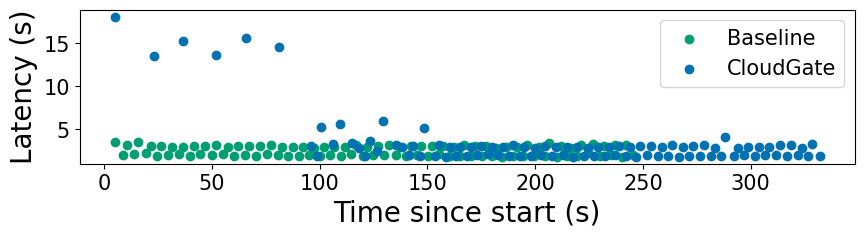

In [86]:
baseline_file = "logs/baseline/interleave-buckets-16-direct-results-2.log"
skydentity_file = "logs/gcp-updated/interleave-buckets-16-skydentity-results-1.log"
plot_timeseries(baseline_file, skydentity_file, 3, "GCP", workload="interleave-buckets")

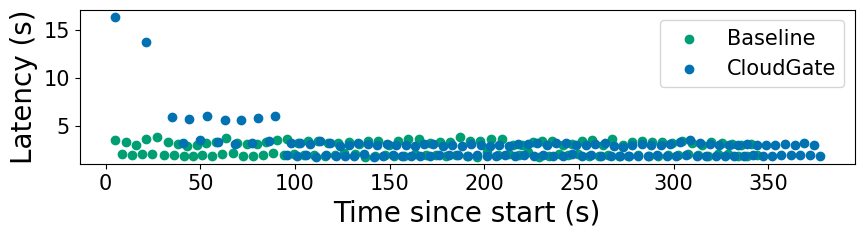

In [87]:
baseline_file = "logs/baseline/interleave-read-write-64-direct-results-2.log"
skydentity_file = "logs/gcp-updated/interleave-read-write-64-skydentity-results-1.log"
plot_timeseries(baseline_file, skydentity_file, 1, "GCP", workload="interleave-read-write")

In [83]:
a = re.compile("skydentity-test-storage-\d+")
b = "2024-04-12 16:21:14,434 INFO concurrent-buckets.py:139 - [skydentity-test-storage-1] Read request 0"
print(a.search(b).group(0))

skydentity-test-storage-1


{'skydentity-test-storage-1-upload': 5.049, 'skydentity-test-storage-2-upload': 5.059, 'skydentity-test-storage-3-upload': 5.069, 'skydentity-test-storage-4-upload': 5.079, 'skydentity-test-storage-5-upload': 5.091, 'skydentity-test-storage-6-upload': 5.104, 'skydentity-test-storage-7-upload': 5.116, 'skydentity-test-storage-8-upload': 5.129, 'skydentity-test-storage-9-upload': 5.142, 'skydentity-test-storage-10-upload': 5.154, 'skydentity-test-storage-11-upload': 5.166, 'skydentity-test-storage-12-upload': 5.178, 'skydentity-test-storage-13-upload': 5.191, 'skydentity-test-storage-14-upload': 5.207, 'skydentity-test-storage-15-upload': 5.217, 'skydentity-test-storage-16-upload': 5.233, 'skydentity-test-storage-1-download': 14.784, 'skydentity-test-storage-2-download': 14.794, 'skydentity-test-storage-3-download': 14.805, 'skydentity-test-storage-4-download': 14.817, 'skydentity-test-storage-5-download': 14.828, 'skydentity-test-storage-6-download': 14.838, 'skydentity-test-storage-7-d

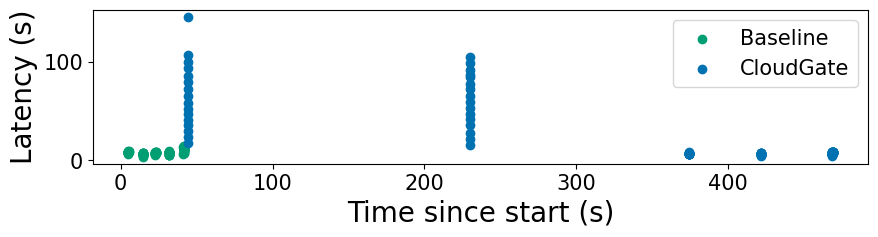

In [88]:
baseline_file = "logs/baseline/concurrent-buckets-16-direct-results-2.log"
skydentity_file = "logs/gcp-updated/concurrent-buckets-16-skydentity-results-1.log"
plot_timeseries(baseline_file, skydentity_file, 16, "GCP", workload="concurrent")